# Introduction

![](https://raw.githubusercontent.com/Fournierp/OCR/master/CAPTCHA/samples/2b827.png)

This notebook is an attempt at solving a CAPTCHA test. This CAPTCHA is an 5 letter with noise (a blur and line that crosses the word). I attempted to process the CAPTCHAs with OpenCV by deblurring, thresholding etc to segment the words. Yet the results remained unconclusive due to the line crossing the entire word, forcing me to hardcoding the coordinates of the letter to extract. 

This brute force approach was very inaccurate, so I explored Deep Learning methods to get a reliable letter prediciton. The model I developped is a Convolutional Neural Network which is efficient at classifying images. Yet the challenge of the data is that we have a single sample per label and could have in testing, some unseen labels. Thus, instead of predicting the label itself, we will train our model to recognize each one of the five letters subsequently.

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, Input, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import backend as K

import os
import cv2
import string

# Data Preprocessing

In [2]:
# All symbols CAPTCHA can contain
symbols = string.ascii_lowercase + "0123456789"

path = '../input/samples/samples'

In [3]:
# Train-Test split
split = .8

def load_images():
    # Create the numpy array of the data
    n_samples = int(len(os.listdir(path)) * split)
    x = np.zeros((n_samples, 50, 200, 1))
    y = np.zeros((n_samples, 5, len(symbols)))
    # For each image in the train directory
    for i, pic in enumerate(os.listdir(path)):
        # Stop when reaching test set
        if(i >= n_samples):
            break
            
        label = pic[:-4]

        # Load the image
        img = cv2.imread(os.path.join('../input/samples/samples', pic), cv2.IMREAD_GRAYSCALE)
        img = img / 255.
        x[i, :, :, 0] = img

        # Load the labels
        target = np.zeros((5, len(symbols)))
        # OneHot Encode the label
        for letter_index, symbol in enumerate(label):
            index = symbols.find(symbol)
            target[letter_index, index] = 1
        y[i, :, :] = target
        
    return x, y
        
x, y = load_images()

# Exploratory Data Analysis

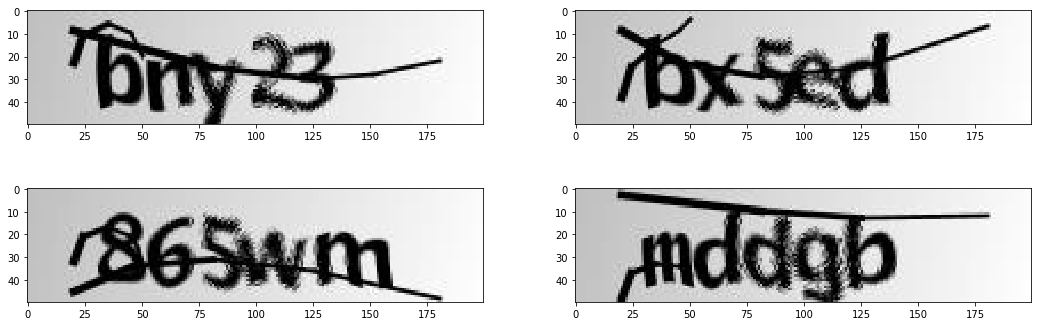

In [4]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 6))
plt.gray()
g = ax1.imshow(x[0][:, :, 0])
g = ax2.imshow(x[1][:, :, 0])
g = ax3.imshow(x[2][:, :, 0])
g = ax4.imshow(x[3][:, :, 0])


# Data Augmentation

This step is made to generate a new set of data samples to train the model on from the given data. Given that we have a limited dataset (~1000 samples) but a high number of labels to predict (5), we need to artificially create more data.

Because letters are not symmetrical, we must only focus on creating more data points by rotating, zooming and shifting the original data.



In [5]:
datagen = ImageDataGenerator(
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,       # Randomly zoom image 
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
)

# Model Design

In [6]:
def model(input_shape, output_shape):
    
    x = Input(shape=input_shape)
    hidden = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
    hidden = Conv2D(32, kernel_size=(3, 3), activation='relu')(hidden)
    hidden = MaxPool2D((2, 2))(hidden)

    hidden = BatchNormalization()(hidden)
    hidden = Conv2D(64, kernel_size=(3, 3), activation='relu')(hidden)
    hidden = Conv2D(64, kernel_size=(3, 3), activation='relu')(hidden)
    hidden = MaxPool2D((2, 2))(hidden)

    hidden = BatchNormalization()(hidden)
    hidden = Flatten()(hidden)
    
    # Make 5 branches from it, each responsible of predicting one letter
    outs = []
    for _ in range(5):
        branch = Dense(128, activation='relu')(hidden)
        drop = Dropout(0.2)(branch)
        res = Dense(len(symbols), activation='sigmoid')(drop)
        outs.append(res)
    
    return Model(inputs=x, outputs=outs)

model = model((x.shape[1], x.shape[2], 1), len(symbols))

In [7]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

model.compile(loss=categorical_crossentropy, optimizer=optimizer, 
              metrics=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy',
                       'categorical_crossentropy', 'categorical_crossentropy'])

# Training 

In [8]:
for i in range(30):
    print("Epoch: ", i)
    # Reset images
    x_gen = x.copy()
    # For each image
    for i in range(len(x)):
        # Randomly
        if(np.random.randint(10) > 7):
            # Apply random transform
            x_gen[i] = datagen.random_transform(x[i])
    # Train for an epoch
    history = model.fit(x_gen, [y[:, 0], y[:, 1], y[:, 2], y[:, 3], y[:, 4]],
                        epochs = 1,
                        batch_size = 16,
                        verbose = 0,
                        validation_split=0.2)

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29


# Model Evaluation

In [9]:
import difflib

# Define function to predict captcha
def predict(filepath):
    label = filepath[-9:-4]
    # Load image 
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    # Normalize
    img = img / 255.
    # Predict CAPTCHA
    prediction = model.predict(img[np.newaxis, :, :, np.newaxis])
    ans = np.reshape(np.array(prediction), (5, 36))
    
    letter_index = []
    # For each letter in the CAPTCHA
    for a in ans:
        # Find which symbol the model predicted
        letter_index.append(np.argmax(a))

    # Construct the predicted CAPTCHA
    capt = ''
    for l in letter_index:
        capt += symbols[l]
        
    # Find prediction match
    match = difflib.SequenceMatcher(None, label, capt,).ratio()

    return capt, match

In [10]:
def eval():
    n_samples = int(len(os.listdir(path)) * split)
    partial_accuracy = 0
    total_accuracy = 0
    # For each image in the test directory
    for i, pic in enumerate(os.listdir(path)):
        if(i > n_samples):
            # Predict
            prediction, acc = predict(os.path.join('../input/samples/samples', pic))
            # Gather model metrics
            if(acc == 1):
                total_accuracy += 1
            partial_accuracy += acc
            print(pic[:-4], prediction)
            
    # Average the accuracy
    return total_accuracy / int(len(os.listdir(path)) * (1 - split)), partial_accuracy / int(len(os.listdir(path)) * (1 - split))

In [11]:
print(eval())

6e6pn 6e6pn
nmw46 nmw48
325fb 3257n
g247w g247y
g3dy6 g3dy6
5np4m 5mp4n
5p3mm 5p3nm
6wnyc 6wnyc
xdn65 xdn65
m67b3 m62b5
gcx6f gcx6f
2356g 2356g
dbfen dbfen
wm746 wwn4b
e2d66 e2d56
y4n6m y4n6n
4d22m 4d22n
c6f8g cff8y
nm46n nm46n
84w7x 84w7x
wnpec wyp7e
xce8d xc28d
ppwyd pmwwy
mwxwp mwwxy
cy3nw c73nw
x347n x347n
mcg43 mcg4y
ny5dp ny5gp
cfc56 cfc5f
33b22 33b7c
f753f f758f
g78gn g78gn
d2n8x d2n8x
b35f6 b35ff
w4cdc w4cdc
n3xfg n3xfg
46mbm 46nbn
nnf8b nnf8b
e6b7y e6b7y
wye85 wy625
4w76g 4w6cg
ygce8 ygcc8
mmg2m mmd2n
6e554 6e554
x458w x458y
y7x8p y7x8p
7xcyd 7xcyd
nw5b2 nwcb2
yy824 yx224
d7nn3 d7nn3
pw5nc pw57x
7b4bm 7w4bn
6c3p5 6c3p5
2w4y7 2wyb7
7p852 7p652
42nxy 42nxy
g7fmc g7fnf
7gp47 7gn47
mdyp7 ndyp7
nngxc nngxc
7g3nf 7g3nf
d3c7y d3c7y
ny8np ny6np
6fg8c 6fg8c
de7f8 de7nx
pcmcc ncncc
4yc85 4yc85
c55c6 c5ex7
23mdg 23m7g
53wp3 53wp8
5nxnn 5ncnn
8nbew 8nbey
7gce6 7gcc6
3d7bd 3y7b7
cffp4 cffp4
3p4nn 3n4nw
x8e8n x8c8n
5dxnm 5dxmn
b4d7c b4d7c
7gmf3 7gn78
cfc2y cfc8y
x38fn x38fn
p5nce n5nce
mg5n